In [57]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers
from tensorflow.keras import losses

In [58]:
def generar_diccionario(textos, sw, N):
    cv = CountVectorizer(stop_words = sw, max_features = N)
    cv.fit_transform(textos)
    diccionario = cv.vocabulary_
    diccionario = dict([(palabra, i+2) for i, palabra in enumerate(diccionario)])
    diccionario['DESC'] = 0
    diccionario['PAD'] = 1 
    return diccionario

In [59]:
def procesar_cadena(texto, diccionario, stop_words, T):
    # Identificar palabras en el texto
    palabras = re.findall(r'\b\w+\b', texto.lower())
    palabras = list(filter(lambda x: x not in stop_words, palabras))
    resultado = [] 
    for i in range(0, T):
        if i < len(palabras): 
            if palabras[i] in diccionario:
                resultado.append(diccionario[palabras[i]])
            else:
                resultado.append(diccionario['DESC'])
        else:
            resultado.append(diccionario['PAD'])
    return np.array(resultado)

In [60]:
# Parámetros configurables
N = 20000  # Número de palabras del diccionario
T = 100    # Longitud prefijada de la reseña
EPOCHS = 10
NEURONAS_CAPA = 128

stop_words=['a', 'about', 'an', 'and', 'as', 'at', 'be', 'because', 'been', 
    'being', 'by', 'during', 'each', 'for', 'from', 'he', 'he\'d', 'he\'ll',
    'he\'s', 'her', 'him', 'his', 'how', 'i', 'i\'d', 'i\'ll', 'i\'m', 'i\'ve',
    'if', 'in', 'into', 'it', 'it\'s', 'its', 'let\'s', 'of', 'or', 'our', 
    'out', 'over', 'same', 'she', 'she\'d', 'she\'ll', 'she\'s', 'so', 'some'
    'such', 'than', 'that', 'that\'s', 'the', 'them', 'then', 'there', 'these',
    'they', 'they\'d', 'they\'ll', 'they\'re', 'they\'ve', 'this', 'those',
    'through', 'to', 'until', 'very', 'we', 'we\'d', 'we\'ll', 'we\'re', 
    'we\'ve', 'what', 'what\'s', 'when', 'when\'s', 'where', 'where\'s', 'which',
    'while', 'who', 'who\'s', 'whom', 'why', 'why\'s', 'with', 'would', 
    'wouldn\'t', 'you', 'you\'d', 'you\'ll', 'you\'re', 'you\'ve', 'your', 
    'yours', 'let', 'll', 're', 've', 'wouldn']


path = "/kaggle/input/tripadvisor-ejercicio/tripadvisor_hotel_reviews.csv"

datos = pd.read_csv(path)

In [61]:
datos.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [62]:
# Variable objetivo
y = datos.iloc[:, -1]
num_clases = len(y.unique())
# Codificamos con "one hot" las posibles categorías finales
y = pd.get_dummies(datos['Rating'], columns=['Rating'])

# Textos de reseñas
textos = datos['Review']
X = []
diccionario = generar_diccionario(textos, stop_words, N)
for texto in textos:
    X.append(procesar_cadena(texto, diccionario, stop_words, T))
# X contendrá las reseñas codificadas y rellenas con la misma longitud
X = np.array(X)

In [63]:
# Categorías finales con one hot
print(y)

           1      2      3      4      5
0      False  False  False   True  False
1      False   True  False  False  False
2      False  False   True  False  False
3      False  False  False  False   True
4      False  False  False  False   True
...      ...    ...    ...    ...    ...
20486  False  False  False  False   True
20487  False  False  False   True  False
20488  False   True  False  False  False
20489   True  False  False  False  False
20490  False   True  False  False  False

[20491 rows x 5 columns]


In [64]:
print(textos)

0        nice hotel expensive parking got good deal sta...
1        ok nothing special charge diamond member hilto...
2        nice rooms not 4* experience hotel monaco seat...
3        unique, great stay, wonderful time hotel monac...
4        great stay great stay, went seahawk game aweso...
                               ...                        
20486    best kept secret 3rd time staying charm, not 5...
20487    great location price view hotel great quick pl...
20488    ok just looks nice modern outside, desk staff ...
20489    hotel theft ruined vacation hotel opened sept ...
20490    people talking, ca n't believe excellent ratin...
Name: Review, Length: 20491, dtype: object


In [65]:
first_key, first_value = next(iter(diccionario.items()))
print(first_key, first_value)

nice 2


In [66]:
print(X)

[[    2     3     4 ...     1     1     1]
 [   77    78    79 ...   131   144   130]
 [    2   229    38 ...   277    22   278]
 ...
 [   77    55  1628 ...     1     1     1]
 [    3 10486  3935 ... 15282     0     0]
 [   51    52   684 ...     1     1     1]]


In [67]:
X.shape

(20491, 100)

In [68]:
y.shape[1]

5

In [69]:
X.shape[1]

100

In [70]:
model = Sequential([
  layers.Input(shape=(X.shape[1], 1)),  # Solo longitud de secuencia (100)
  layers.LSTM(units=125, activation="tanh"),
  #layers.Dropout(0.2),
  #layers.GlobalAveragePooling1D(),
  #layers.Dropout(0.2),
  layers.Dense(5, activation='softmax')
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                       │ (None, 125)                 │          63,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             630 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,130 (250.51 KB)

 Trainable params: 64,130 (250.51 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history = model.fit(X, y, epochs=EPOCHS)

Epoch 1/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4427 - loss: 1.3689
Epoch 2/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4411 - loss: 1.3543
Epoch 3/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4462 - loss: 1.3516
Epoch 4/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4551 - loss: 1.3335
Epoch 5/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4706 - loss: 1.3179
Epoch 6/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4747 - loss: 1.3112
Epoch 7/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4782 - loss: 1.3007
Epoch 8/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4858 - loss: 1.2948
Epoch 9/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4875 - loss: 1.2878
Epoch 10/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4859 - loss: 1.2821


In [72]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss'])

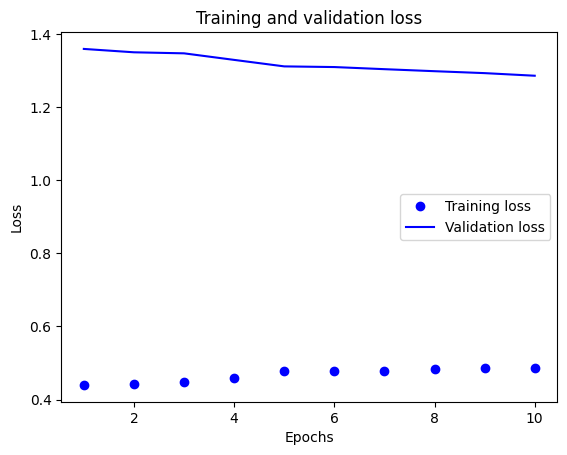

In [74]:
acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()